In [ ]:
# https://velog.io/@krec7748/Pytorch-EfficientNet-%EA%B5%AC%ED%98%84

In [ ]:
#https://keep-steady.tistory.com/35

In [1]:
!git clone https://github.com/lukemelas/EfficientNet-PyTorch
!cd EfficientNet-PyTorch && pip install -e .

Cloning into 'EfficientNet-PyTorch'...
remote: Enumerating objects: 665, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 665 (delta 26), reused 58 (delta 23), pack-reused 595 (from 1)
Receiving objects: 100% (665/665), 1.14 MiB | 31.61 MiB/s, done.
Resolving deltas: 100% (342/342), done.
Obtaining file:///content/EfficientNet-PyTorch
  Preparing metadata (setup.py) ... done
  Running setup.py develop for efficientnet_pytorch


In [2]:
pip show efficientnet-pytorch

Name: efficientnet_pytorch
Version: 0.7.1
Summary: EfficientNet implemented in PyTorch.
Home-page: https://github.com/lukemelas/EfficientNet-PyTorch
Author: Luke
Author-email: lmelaskyriazi@college.harvard.edu
License: Apache
Location: /content/EfficientNet-PyTorch
Editable project location: /content/EfficientNet-PyTorch
Requires: torch
Required-by: 


In [1]:
# 구글 드라이브와 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os

# 지정한 경로의 파일 및 폴더 목록 가져오기
files = os.listdir('/content/drive/MyDrive/24-2 딥러닝')  # 디렉토리 경로를 지정하세요.
print(files)

['train', 'test', 'EfficientNet-PyTorch', 'adam_32_lr1_0.0002.pt', '우리가 직접 모은 패널 사진']


In [3]:
  import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import copy
import random

In [4]:
import os

# Google Drive에 있는 프로젝트 폴더 내용 출력
files = os.listdir('/content/drive/MyDrive/24-2 딥러닝')  # 경로를 적절히 변경
print(files)

['train', 'test', 'EfficientNet-PyTorch', 'adam_32_lr1_0.0002.pt', '우리가 직접 모은 패널 사진']


#train

- 시드 고정

In [5]:
import torch
import random

# 시드(seed) 고정
random_seed = 2024
torch.manual_seed(random_seed)
import numpy as np
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
import cv2
import numpy as np

target_size = (224,224)

def load_dataset(groups_folder_path, categories):

    Y = []
    X = []

    for idx, category in enumerate(categories):
        label = idx  # 정수 레이블로 변경
        image_dir = os.path.join(groups_folder_path, category)

        file_list = os.listdir(image_dir)

        for filename in file_list:
            if filename.lower().endswith('.jpg'):
                url = os.path.join(image_dir, filename)
                img = cv2.imread(url)
                if img is not None:  # 이미지를 성공적으로 읽었는지 확인
                     img_resized = cv2.resize(img, target_size)
                     X.append(img_resized)
                     Y.append(label)

    return X, Y

train_folder_path = os.path.join('/content/drive/MyDrive/24-2 딥러닝', 'train')
test_folder_path = os.path.join('/content/drive/MyDrive/24-2 딥러닝', 'test')

categories = ['Physical-Damage', 'Electrical-damage', 'Snow-Covered', 'Dusty', 'Bird-drop', 'Clean']

X_train, Y_train = load_dataset(train_folder_path, categories)
X_test, Y_test = load_dataset(test_folder_path, categories)



In [7]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

print(f"train 이미지 데이터 shape: {X_train.shape}")
print(f"train 레이블 데이터 shape: {Y_train.shape}")

print(f"test 이미지 데이터 shape: {X_test.shape}")
print(f"test 레이블 데이터 shape: {Y_test.shape}")

print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))

train 이미지 데이터 shape: (700, 224, 224, 3)
train 레이블 데이터 shape: (700,)
test 이미지 데이터 shape: (165, 224, 224, 3)
test 레이블 데이터 shape: (165,)
(array([0, 1, 2, 3, 4, 5]), array([ 55,  80,  98, 152, 162, 153]))
(array([0, 1, 2, 3, 4, 5]), array([13, 18, 25, 33, 40, 36]))


#데이터 전처리 및 증강

- 학습 데이터와 검증 데이터 4:1 분할

In [8]:
from sklearn.model_selection import train_test_split

# 1. 전체 데이터에서 훈련 데이터(80%)와 검증 데이터(20%) 분할
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


# 분할된 데이터 크기 확인
print(f"훈련 데이터 크기: {x_train.shape}")
print("y_train shape:", y_train.shape)
print(f"검증 데이터 크기: {x_valid.shape}")
print("y_valid shape:", y_valid.shape)

print("x_test shape:", X_test.shape)
print("y_test shape:", Y_test.shape)


훈련 데이터 크기: (560, 224, 224, 3)
y_train shape: (560,)
검증 데이터 크기: (140, 224, 224, 3)
y_valid shape: (140,)
x_test shape: (165, 224, 224, 3)
y_test shape: (165,)


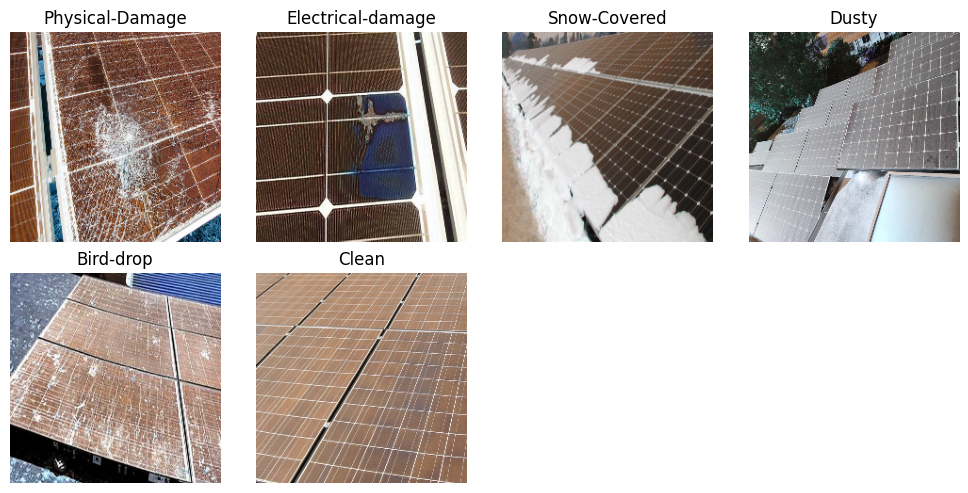

In [9]:
import matplotlib.pyplot as plt

# 클래스별로 이미지 하나씩 시각화
num_classes = len(categories)

# 각 클래스의 첫 번째 이미지 인덱스 찾기
class_first_indices = [np.where(Y_train == i)[0][0] for i in range(num_classes)]

# 이미지 출력 설정
plt.figure(figsize=(10, 5))
for i, idx in enumerate(class_first_indices):
    plt.subplot(2, 4, i + 1)  # 2행 5열의 subplot을 만들고 각 클래스별 이미지 출력
    plt.imshow(X_train[idx])
    plt.title(categories[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

- 데이터 증강 및 정규화 정의

In [10]:
from torchvision import transforms

# For normalization, ImageNet 데이터셋에 사용된 평균과 표준편차 사용
in_mean = (0.485, 0.456, 0.406)
in_std = (0.229, 0.224, 0.225)

# 데이터 증강 정의 (학습 데이터셋에만 적용)

# transofrms.Normalize((R채널 평균, G채널 평균, B채널 평균), (R채널 표준편차, G채널 표준편차, B채널 표준편차))

# 증강 확률의 기본값은 0.5
train_transform = transforms.Compose([
    transforms.ToPILImage(),  # NumPy 배열을 PIL 이미지로 변환
    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 좌우 반전
    transforms.ToTensor(),  # Tensor로 변환
    transforms.RandomGrayscale(p=0.2),  # 20% 확률로 흑백 변환
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # 랜덤 영역 제거
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 정규화
])

# 검증 및 테스트 데이터셋에는 증강 적용 안 함
test_transform = transforms.Compose([
    transforms.ToTensor(), #  0 ~ 1 범위로 변환
    transforms.Normalize(in_mean, in_std) # 사전에 정의한 평균과 표준편차를 사용하여 정규화
])

- 사용자 정의 데이터셋 클래스

In [11]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y, mode='train'):  # mode 인자 추가
        self.X = X
        self.y = torch.tensor(y, dtype=torch.long)
        self.mode = mode  # mode 저장

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.mode == 'train':
            x = train_transform(x)
        else:  # 'valid' 또는 'test'
            x = test_transform(x)
        y = self.y[idx]
        return x, y

- DataLoader 생성

In [12]:
from torch.utils.data import Dataset, DataLoader

# Dataset 생성
train_dataset = CustomDataset(x_train, y_train, mode='train')    #증강 적용
valid_dataset = CustomDataset(x_valid, y_valid, mode='valid')
test_dataset = CustomDataset(X_test, Y_test, mode='test')


## data loader 선언
dataloaders, batch_num = {}, {}
batch_size = 32

dataloaders['train'] = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)   # 학습 로더에서 나오는 데이터는 항상 섞어줍니다
dataloaders['valid'] = DataLoader(valid_dataset,batch_size=batch_size, shuffle=False)  # 평가를 위해서 순차적으로 나오게 합니다
dataloaders['test'] = DataLoader(test_dataset,batch_size=batch_size, shuffle=False)  # 평가를 위해서 순차적으로 나오게 합니다

batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  train,valid,test : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 32,  train,valid,test : 18 / 5 / 6


- 증강 데이터 시각화

train batch 0: torch.Size([32, 3, 224, 224])
tensor([2, 5, 3, 0, 5, 4, 3, 1, 4, 3, 3, 4, 5, 3, 4, 4, 4, 1, 4, 4, 1, 2, 1, 5,
        4, 5, 5, 3, 5, 2, 0, 5])


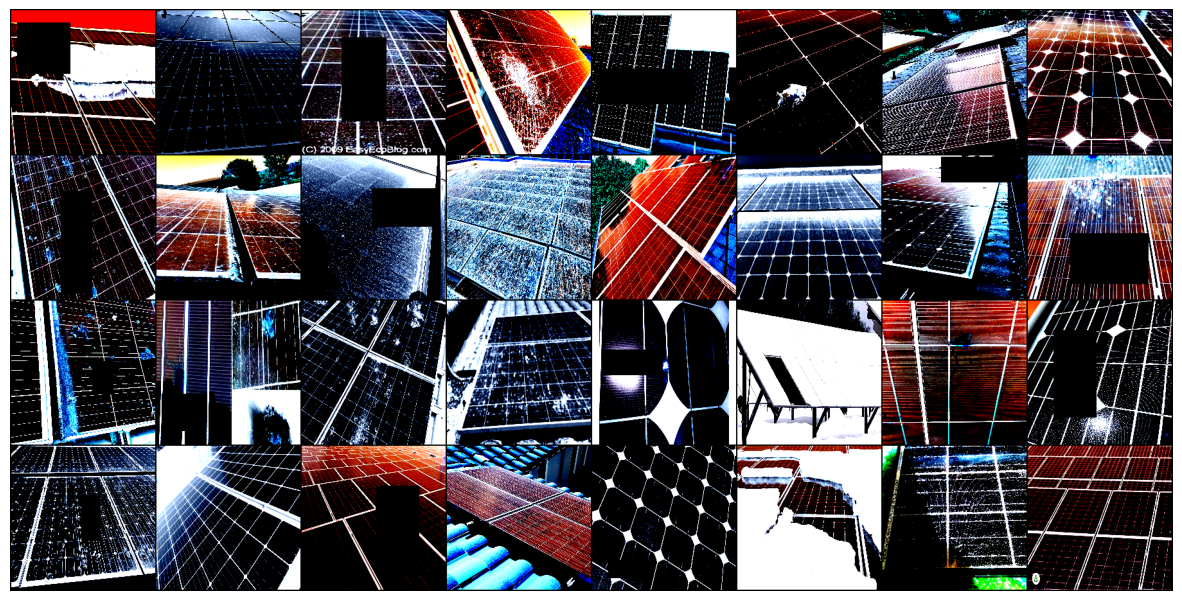

In [13]:
import torchvision

# 첫 번째 배치 데이터 가져오기
for i, (images, labels) in enumerate(dataloaders['train']):
    print(f"train batch {i}: {images.shape}")
    break

# Figure 크기 설정
plt.figure(figsize=(15, 10))
print(labels)
# 이미지 시각화
img_grid = torchvision.utils.make_grid(images)
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

##모든 레이어 freeze

->  EfficientNet의 모든 레이어를 학습시키려면 대규모의 데이터셋이 필요하지만, 데이터셋이 충분히 크지 않기에 모델의 모든 레이어를 학습시키는 것이 오히려 일반화 성능에 부정적. 사전 학습된 레이어를 freeze하면 모델이 데이터 부족으로 인해 가중치가 과도하게 변동되는 것을 방지할 수 있음

In [14]:
## 학습 코드
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=6)

224


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 40.1MB/s]

Loaded pretrained weights for efficientnet-b0


In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()

            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [16]:
model = model.to(device)


dropout_rate = 0.3  # 원하는 Dropout 확률 설정
model._dropout = nn.Dropout(p=dropout_rate)

# 모델 전체에 추가적인 Dropout 레이어를 추가하고자 한다면 다음과 같이 할 수 있습니다.
# 예를 들어, 마지막 fully connected 층에 추가적인 Dropout을 적용
additional_dropout = nn.Sequential(
    model,
    nn.Dropout(p=0.5)
)

# 이제 추가된 Dropout이 포함된 모델을 학습에 사용하면 됩니다.
model = additional_dropout.to(device)

criterion = nn.CrossEntropyLoss()



optimizer_ft = optim.Adam(model.parameters(), lr=0.01)


lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [17]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=70)

Epoch 0/69
----------
train Loss: 2.51 Acc: 23.6
valid Loss: 4869855.39 Acc: 20.0
==> best model saved - 0 / 20.0
Epoch 1/69
----------
train Loss: 2.67 Acc: 21.4
valid Loss: 129524642.97 Acc: 15.0
Epoch 2/69
----------
train Loss: 2.27 Acc: 19.5
valid Loss: 33381735.31 Acc: 21.4
==> best model saved - 2 / 21.4
Epoch 3/69
----------
train Loss: 1.89 Acc: 23.8
valid Loss: 456471.00 Acc: 21.4
Epoch 4/69
----------
train Loss: 1.73 Acc: 25.0
valid Loss: 77123.84 Acc: 21.4
Epoch 5/69
----------
train Loss: 1.69 Acc: 30.9
valid Loss: 8005.33 Acc: 21.4
Epoch 6/69
----------
train Loss: 1.63 Acc: 33.8
valid Loss: 312.16 Acc: 21.4
Epoch 7/69
----------
train Loss: 1.60 Acc: 34.3
valid Loss: 159.56 Acc: 22.1
==> best model saved - 7 / 22.1
Epoch 8/69
----------
train Loss: 1.59 Acc: 31.4
valid Loss: 202.44 Acc: 17.9
Epoch 9/69
----------
train Loss: 1.49 Acc: 35.0
valid Loss: 11.57 Acc: 24.3
==> best model saved - 9 / 24.3
Epoch 10/69
----------
train Loss: 1.47 Acc: 37.9
valid Loss: 4.73 Acc: 

best model : 55 - 75 / 0.9


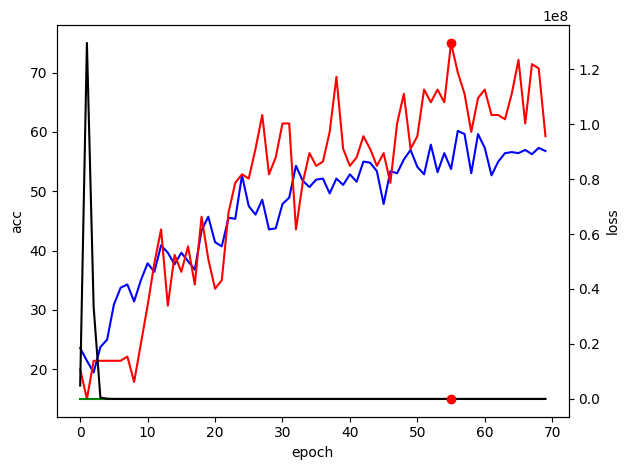

In [18]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [19]:
# 새로운 파일 이름으로 모델 저장
torch.save(model.state_dict(), 'b0_2.pt')

In [20]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# 모델 구조 정의 (훈련에 사용된 동일한 모델 구조이어야 함)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)

# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = additional_dropout.to(device)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('b0_2.pt'))

# 모델을 평가 모드로 전환
model.eval()

# 손실 함수와 평가 지표 정의
criterion = nn.CrossEntropyLoss()

# 정확도와 손실을 계산하는 함수 정의
def evaluate_model(model, dataloader, criterion):
    model.eval()  # 평가 모드로 전환
    running_loss = 0.0
    running_corrects = 0
    num_samples = 0

    with torch.no_grad():  # 평가 시에는 gradient 계산을 하지 않음
        for inputs, labels in dataloader:
            # 입력과 레이블을 GPU로 이동
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 예측 값 구하기
            loss = criterion(outputs, labels)

            # 손실과 정확도 계산
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            num_samples += len(labels)

    epoch_loss = running_loss / num_samples
    epoch_acc = (running_corrects.double() / num_samples).cpu().item() * 100

    return epoch_loss, epoch_acc

# test 데이터셋에 대해 평가
test_loss, test_acc = evaluate_model(model, dataloaders['test'], criterion)

# 결과 출력
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')

Loaded pretrained weights for efficientnet-b0


<ipython-input-20-213f30b3ecbb>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('b0_2.pt'))


Test Loss: 0.9290
Test Accuracy: 67.27%


#batch size 32




## lr = 0.1

In [ ]:
## 학습 코드
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'

image_size = EfficientNet.get_image_size(model_name)
print(image_size)

224


In [ ]:


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()

            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
model = model.to(device)


dropout_rate = 0.3  # 원하는 Dropout 확률 설정
model._dropout = nn.Dropout(p=dropout_rate)

# 모델 전체에 추가적인 Dropout 레이어를 추가하고자 한다면 다음과 같이 할 수 있습니다.
# 예를 들어, 마지막 fully connected 층에 추가적인 Dropout을 적용
additional_dropout = nn.Sequential(
    model,
    nn.Dropout(p=0.3)
)

# 이제 추가된 Dropout이 포함된 모델을 학습에 사용하면 됩니다.
model = additional_dropout.to(device)

criterion = nn.CrossEntropyLoss()



optimizer_ft = optim.Adam(model.parameters(), lr=0.01)


lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 2.28 Acc: 31.2
valid Loss: 14735247.57 Acc: 7.9
==> best model saved - 0 / 7.9
Epoch 1/49
----------
train Loss: 1.69 Acc: 40.2
valid Loss: 34072375.43 Acc: 21.4
==> best model saved - 1 / 21.4
Epoch 2/49
----------
train Loss: 1.46 Acc: 45.5
valid Loss: 61555.51 Acc: 21.4
Epoch 3/49
----------
train Loss: 1.45 Acc: 42.1
valid Loss: 4612.53 Acc: 16.4
Epoch 4/49
----------
train Loss: 1.39 Acc: 49.6
valid Loss: 759.24 Acc: 16.4
Epoch 5/49
----------
train Loss: 1.24 Acc: 51.2
valid Loss: 85.76 Acc: 19.3
Epoch 6/49
----------
train Loss: 1.11 Acc: 56.1
valid Loss: 15.74 Acc: 19.3
Epoch 7/49
----------
train Loss: 1.20 Acc: 54.3
valid Loss: 178.17 Acc: 7.9
Epoch 8/49
----------
train Loss: 1.15 Acc: 53.9
valid Loss: 22.55 Acc: 28.6
==> best model saved - 8 / 28.6
Epoch 9/49
----------
train Loss: 1.11 Acc: 57.9
valid Loss: 6.31 Acc: 45.7
==> best model saved - 9 / 45.7
Epoch 10/49
----------
train Loss: 1.08 Acc: 56.1
valid Loss: 3.58 Acc: 51.4
==> best m

best model : 42 - 76 / 1.5


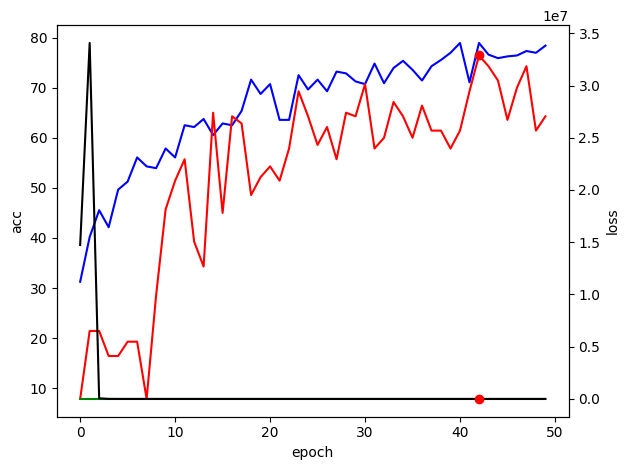

In [ ]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [ ]:
# 새로운 파일 이름으로 모델 저장
torch.save(model.state_dict(), 'b0_1.pt')


In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# 모델 구조 정의 (훈련에 사용된 동일한 모델 구조이어야 함)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)

# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = additional_dropout.to(device)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('b0_1.pt'))

# 모델을 평가 모드로 전환
model.eval()

# 손실 함수와 평가 지표 정의
criterion = nn.CrossEntropyLoss()

# 정확도와 손실을 계산하는 함수 정의
def evaluate_model(model, dataloader, criterion):
    model.eval()  # 평가 모드로 전환
    running_loss = 0.0
    running_corrects = 0
    num_samples = 0

    with torch.no_grad():  # 평가 시에는 gradient 계산을 하지 않음
        for inputs, labels in dataloader:
            # 입력과 레이블을 GPU로 이동
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 예측 값 구하기
            loss = criterion(outputs, labels)

            # 손실과 정확도 계산
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            num_samples += len(labels)

    epoch_loss = running_loss / num_samples
    epoch_acc = (running_corrects.double() / num_samples).cpu().item() * 100

    return epoch_loss, epoch_acc

# test 데이터셋에 대해 평가
test_loss, test_acc = evaluate_model(model, dataloaders['test'], criterion)

# 결과 출력
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')


Loaded pretrained weights for efficientnet-b0


<ipython-input-90-3107f668c11e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('b0_1.pt'))


Test Loss: 1.3642
Test Accuracy: 71.52%


## lr = 0.05

In [ ]:
## 학습 코드
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=6)

224
Loaded pretrained weights for efficientnet-b0


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()

            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
model = model.to(device)


dropout_rate = 0.3  # 원하는 Dropout 확률 설정
model._dropout = nn.Dropout(p=dropout_rate)

# 모델 전체에 추가적인 Dropout 레이어를 추가하고자 한다면 다음과 같이 할 수 있습니다.
# 예를 들어, 마지막 fully connected 층에 추가적인 Dropout을 적용
additional_dropout = nn.Sequential(
    model,
    nn.Dropout(p=0.5)
)

# 이제 추가된 Dropout이 포함된 모델을 학습에 사용하면 됩니다.
model = additional_dropout.to(device)

criterion = nn.CrossEntropyLoss()



optimizer_ft = optim.Adam(model.parameters(), lr=0.05)


lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=51)

Epoch 0/50
----------
train Loss: 7.14 Acc: 16.6
valid Loss: 31309421505281133641728.00 Acc: 20.0
==> best model saved - 0 / 20.0
Epoch 1/50
----------
train Loss: 6.58 Acc: 16.4
valid Loss: 242111833447745.84 Acc: 19.3
Epoch 2/50
----------
train Loss: 4.30 Acc: 20.0
valid Loss: 180732777735.31 Acc: 16.4
Epoch 3/50
----------
train Loss: 3.25 Acc: 14.3
valid Loss: 48276064.00 Acc: 20.0
Epoch 4/50
----------
train Loss: 2.46 Acc: 12.7
valid Loss: 286604.14 Acc: 22.9
==> best model saved - 4 / 22.9
Epoch 5/50
----------
train Loss: 2.03 Acc: 19.1
valid Loss: 20433.95 Acc: 17.1
Epoch 6/50
----------
train Loss: 2.05 Acc: 14.8
valid Loss: 2359.89 Acc: 17.9
Epoch 7/50
----------
train Loss: 2.02 Acc: 17.1
valid Loss: 1672.39 Acc: 15.0
Epoch 8/50
----------
train Loss: 2.03 Acc: 22.5
valid Loss: 823.54 Acc: 15.0
Epoch 9/50
----------
train Loss: 1.99 Acc: 25.7
valid Loss: 453.60 Acc: 15.0
Epoch 10/50
----------
train Loss: 1.89 Acc: 25.2
valid Loss: 95.19 Acc: 15.7
Epoch 11/50
----------
tr

best model : 50 - 56 / 1.4


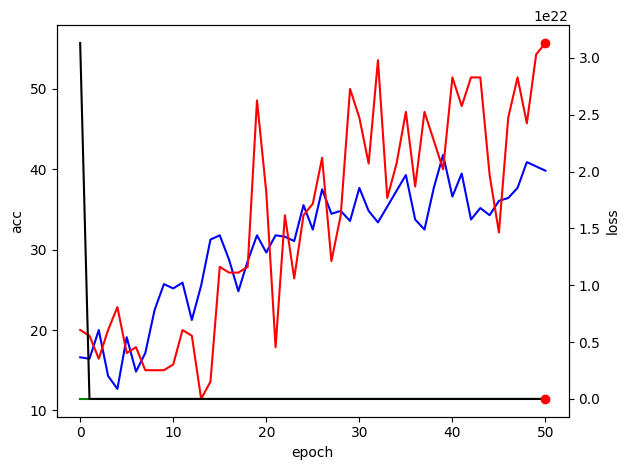

In [ ]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [ ]:
# 새로운 파일 이름으로 모델 저장
torch.save(model.state_dict(), 'b0_1.pt')

In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# 모델 구조 정의 (훈련에 사용된 동일한 모델 구조이어야 함)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)

# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = additional_dropout.to(device)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('b0_1.pt'))

# 모델을 평가 모드로 전환
model.eval()

# 손실 함수와 평가 지표 정의
criterion = nn.CrossEntropyLoss()

# 정확도와 손실을 계산하는 함수 정의
def evaluate_model(model, dataloader, criterion):
    model.eval()  # 평가 모드로 전환
    running_loss = 0.0
    running_corrects = 0
    num_samples = 0

    with torch.no_grad():  # 평가 시에는 gradient 계산을 하지 않음
        for inputs, labels in dataloader:
            # 입력과 레이블을 GPU로 이동
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 예측 값 구하기
            loss = criterion(outputs, labels)

            # 손실과 정확도 계산
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            num_samples += len(labels)

    epoch_loss = running_loss / num_samples
    epoch_acc = (running_corrects.double() / num_samples).cpu().item() * 100

    return epoch_loss, epoch_acc

# test 데이터셋에 대해 평가
test_loss, test_acc = evaluate_model(model, dataloaders['test'], criterion)

# 결과 출력
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')


Loaded pretrained weights for efficientnet-b0


<ipython-input-97-3107f668c11e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('b0_1.pt'))


Test Loss: 1.3994
Test Accuracy: 49.09%


## lr = 0.01

In [ ]:
## 학습 코드
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=6)

224
Loaded pretrained weights for efficientnet-b0


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()

            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
model = model.to(device)


dropout_rate = 0.3  # 원하는 Dropout 확률 설정
model._dropout = nn.Dropout(p=dropout_rate)

# 모델 전체에 추가적인 Dropout 레이어를 추가하고자 한다면 다음과 같이 할 수 있습니다.
# 예를 들어, 마지막 fully connected 층에 추가적인 Dropout을 적용
additional_dropout = nn.Sequential(
    model,
    nn.Dropout(p=0.3)
)

# 이제 추가된 Dropout이 포함된 모델을 학습에 사용하면 됩니다.
model = additional_dropout.to(device)

criterion = nn.CrossEntropyLoss()



optimizer_ft = optim.Adam(model.parameters(), lr=0.01)


lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=51)

Epoch 0/50
----------
train Loss: 1.77 Acc: 37.7
valid Loss: 3610074.54 Acc: 17.1
==> best model saved - 0 / 17.1
Epoch 1/50
----------
train Loss: 1.50 Acc: 42.1
valid Loss: 87404.90 Acc: 24.3
==> best model saved - 1 / 24.3
Epoch 2/50
----------
train Loss: 1.44 Acc: 47.1
valid Loss: 11789.99 Acc: 21.4
Epoch 3/50
----------
train Loss: 1.28 Acc: 51.1
valid Loss: 1860.08 Acc: 23.6
Epoch 4/50
----------
train Loss: 1.23 Acc: 54.5
valid Loss: 86.18 Acc: 7.9
Epoch 5/50
----------
train Loss: 1.15 Acc: 53.6
valid Loss: 81.94 Acc: 10.0
Epoch 6/50
----------
train Loss: 1.33 Acc: 44.8
valid Loss: 14.80 Acc: 18.6
Epoch 7/50
----------
train Loss: 1.11 Acc: 55.4
valid Loss: 4.14 Acc: 28.6
==> best model saved - 7 / 28.6
Epoch 8/50
----------
train Loss: 1.03 Acc: 60.2
valid Loss: 5.11 Acc: 41.4
==> best model saved - 8 / 41.4
Epoch 9/50
----------
train Loss: 1.03 Acc: 59.3
valid Loss: 6.26 Acc: 32.9
Epoch 10/50
----------
train Loss: 1.06 Acc: 58.0
valid Loss: 8.00 Acc: 16.4
Epoch 11/50
----

best model : 38 - 78 / 0.9


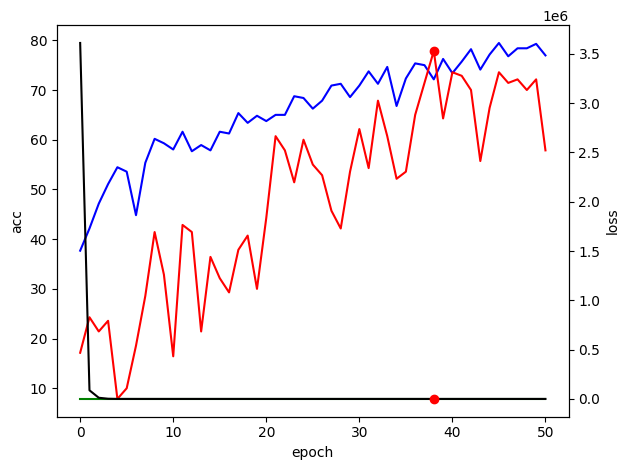

In [ ]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [ ]:
# 새로운 파일 이름으로 모델 저장
torch.save(model.state_dict(), 'b0_1.pt')

In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# 모델 구조 정의 (훈련에 사용된 동일한 모델 구조이어야 함)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)

# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = additional_dropout.to(device)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('b0_1.pt'))

# 모델을 평가 모드로 전환
model.eval()

# 손실 함수와 평가 지표 정의
criterion = nn.CrossEntropyLoss()

# 정확도와 손실을 계산하는 함수 정의
def evaluate_model(model, dataloader, criterion):
    model.eval()  # 평가 모드로 전환
    running_loss = 0.0
    running_corrects = 0
    num_samples = 0

    with torch.no_grad():  # 평가 시에는 gradient 계산을 하지 않음
        for inputs, labels in dataloader:
            # 입력과 레이블을 GPU로 이동
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 예측 값 구하기
            loss = criterion(outputs, labels)

            # 손실과 정확도 계산
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            num_samples += len(labels)

    epoch_loss = running_loss / num_samples
    epoch_acc = (running_corrects.double() / num_samples).cpu().item() * 100

    return epoch_loss, epoch_acc

# test 데이터셋에 대해 평가
test_loss, test_acc = evaluate_model(model, dataloaders['test'], criterion)

# 결과 출력
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')


Loaded pretrained weights for efficientnet-b0


<ipython-input-105-3107f668c11e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('b0_1.pt'))


Test Loss: 1.1471
Test Accuracy: 72.73%


# batch size 64

## lr = 0.1

In [21]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# For normalization, ImageNet 데이터셋에 사용된 평균과 표준편차 사용
in_mean = (0.485, 0.456, 0.406)
in_std = (0.229, 0.224, 0.225)

# 데이터 증강 정의 (학습 데이터셋에만 적용)

# transofrms.Normalize((R채널 평균, G채널 평균, B채널 평균), (R채널 표준편차, G채널 표준편차, B채널 표준편차))

# 증강 확률의 기본값은 0.5
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.RandomVerticalFlip(), # 상하 반전
    transforms.RandomHorizontalFlip(), # 좌우 반전
    #transforms.RandomRotation(90), #  (-degree, +degree) 사이만큼 회전
    transforms.RandomGrayscale(), # 흑백화
    transforms.ToTensor(), #  0 ~ 1 범위로 변환
    transforms.RandomErasing(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), #색상 변화에 강한 모델
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),# 크기를 80%~100% 범위로 자른 후 크기를 맞춤
    #transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)), # 이동, 회전, 크기 변경 등을 한 번에 적용
    transforms.Normalize(in_mean, in_std) # 사전에 정의한 평균과 표준편차를 사용하여 정규화
])

# 검증 및 테스트 데이터셋에는 증강 적용 안 함
test_transform = transforms.Compose([
    transforms.ToTensor(), #  0 ~ 1 범위로 변환
    transforms.Normalize(in_mean, in_std) # 사전에 정의한 평균과 표준편차를 사용하여 정규화
])

class CustomDataset(Dataset):
    def __init__(self, X, y, mode='train'):  # mode 인자 추가
        self.X = X
        self.y = torch.tensor(y, dtype=torch.long)
        self.mode = mode  # mode 저장

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.mode == 'train':
            x = train_transform(x)
        else:  # 'valid' 또는 'test'
            x = test_transform(x)
        y = self.y[idx]
        return x, y

# Dataset 생성
train_dataset = CustomDataset(x_train, y_train, mode='train')    #증강 적용
valid_dataset = CustomDataset(x_valid, y_valid, mode='valid')
test_dataset = CustomDataset(X_test, Y_test, mode='test')


## data loader 선언
dataloaders, batch_num = {}, {}
batch_size = 256

dataloaders['train'] = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)   # 학습 로더에서 나오는 데이터는 항상 섞어줍니다
dataloaders['valid'] = DataLoader(valid_dataset,batch_size=batch_size, shuffle=False)  # 평가를 위해서 순차적으로 나오게 합니다
dataloaders['test'] = DataLoader(test_dataset,batch_size=batch_size, shuffle=False)  # 평가를 위해서 순차적으로 나오게 합니다

batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  train,valid,test : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 256,  train,valid,test : 3 / 1 / 1


In [22]:
## 학습 코드
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=6)

224
Loaded pretrained weights for efficientnet-b0


In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()

            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [24]:
model = model.to(device)


dropout_rate = 0.3  # 원하는 Dropout 확률 설정
model._dropout = nn.Dropout(p=dropout_rate)

# 모델 전체에 추가적인 Dropout 레이어를 추가하고자 한다면 다음과 같이 할 수 있습니다.
# 예를 들어, 마지막 fully connected 층에 추가적인 Dropout을 적용
additional_dropout = nn.Sequential(
    model,
    nn.Dropout(p=0.3)
)

# 이제 추가된 Dropout이 포함된 모델을 학습에 사용하면 됩니다.
model = additional_dropout.to(device)

criterion = nn.CrossEntropyLoss()



optimizer_ft = optim.Adam(model.parameters(), lr=0.01)


lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [25]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 100)

Epoch 0/99
----------


OutOfMemoryError: CUDA out of memory. Tried to allocate 184.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 69.06 MiB is free. Process 5634 has 14.68 GiB memory in use. Of the allocated memory 14.33 GiB is allocated by PyTorch, and 217.07 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [ ]:
# 새로운 파일 이름으로 모델 저장
torch.save(model.state_dict(), 'b0_1.pt')

In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# 모델 구조 정의 (훈련에 사용된 동일한 모델 구조이어야 함)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)

# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = additional_dropout.to(device)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('b0_1.pt'))

# 모델을 평가 모드로 전환
model.eval()

# 손실 함수와 평가 지표 정의
criterion = nn.CrossEntropyLoss()

# 정확도와 손실을 계산하는 함수 정의
def evaluate_model(model, dataloader, criterion):
    model.eval()  # 평가 모드로 전환
    running_loss = 0.0
    running_corrects = 0
    num_samples = 0

    with torch.no_grad():  # 평가 시에는 gradient 계산을 하지 않음
        for inputs, labels in dataloader:
            # 입력과 레이블을 GPU로 이동
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 예측 값 구하기
            loss = criterion(outputs, labels)

            # 손실과 정확도 계산
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            num_samples += len(labels)

    epoch_loss = running_loss / num_samples
    epoch_acc = (running_corrects.double() / num_samples).cpu().item() * 100

    return epoch_loss, epoch_acc

# test 데이터셋에 대해 평가
test_loss, test_acc = evaluate_model(model, dataloaders['test'], criterion)

# 결과 출력
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')


## lr = 0.05

In [ ]:
## 학습 코드
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=6)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()

            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
model = model.to(device)


dropout_rate = 0.3  # 원하는 Dropout 확률 설정
model._dropout = nn.Dropout(p=dropout_rate)

# 모델 전체에 추가적인 Dropout 레이어를 추가하고자 한다면 다음과 같이 할 수 있습니다.
# 예를 들어, 마지막 fully connected 층에 추가적인 Dropout을 적용
additional_dropout = nn.Sequential(
    model,
    nn.Dropout(p=0.3)
)

# 이제 추가된 Dropout이 포함된 모델을 학습에 사용하면 됩니다.
model = additional_dropout.to(device)

criterion = nn.CrossEntropyLoss()



optimizer_ft = optim.Adam(model.parameters(), lr=0.01)


lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 51)

In [ ]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [ ]:
# 새로운 파일 이름으로 모델 저장
torch.save(model.state_dict(), 'b0_1.pt')

In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# 모델 구조 정의 (훈련에 사용된 동일한 모델 구조이어야 함)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)

# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = additional_dropout.to(device)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('b0_1.pt'))

# 모델을 평가 모드로 전환
model.eval()

# 손실 함수와 평가 지표 정의
criterion = nn.CrossEntropyLoss()

# 정확도와 손실을 계산하는 함수 정의
def evaluate_model(model, dataloader, criterion):
    model.eval()  # 평가 모드로 전환
    running_loss = 0.0
    running_corrects = 0
    num_samples = 0

    with torch.no_grad():  # 평가 시에는 gradient 계산을 하지 않음
        for inputs, labels in dataloader:
            # 입력과 레이블을 GPU로 이동
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 예측 값 구하기
            loss = criterion(outputs, labels)

            # 손실과 정확도 계산
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            num_samples += len(labels)

    epoch_loss = running_loss / num_samples
    epoch_acc = (running_corrects.double() / num_samples).cpu().item() * 100

    return epoch_loss, epoch_acc

# test 데이터셋에 대해 평가
test_loss, test_acc = evaluate_model(model, dataloaders['test'], criterion)

# 결과 출력
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')


## lr = 0.01

In [ ]:
## 학습 코드
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=6)

224
Loaded pretrained weights for efficientnet-b0


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()

            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
model = model.to(device)


dropout_rate = 0.3  # 원하는 Dropout 확률 설정
model._dropout = nn.Dropout(p=dropout_rate)

# 모델 전체에 추가적인 Dropout 레이어를 추가하고자 한다면 다음과 같이 할 수 있습니다.
# 예를 들어, 마지막 fully connected 층에 추가적인 Dropout을 적용
additional_dropout = nn.Sequential(
    model,
    nn.Dropout(p=0.3)
)

# 이제 추가된 Dropout이 포함된 모델을 학습에 사용하면 됩니다.
model = additional_dropout.to(device)

criterion = nn.CrossEntropyLoss()



optimizer_ft = optim.Adam(model.parameters(), lr=0.01)


lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 100)

Epoch 0/99
----------
train Loss: 0.31 Acc: 79.8
valid Loss: 1.63 Acc: 72.1
==> best model saved - 0 / 72.1
Epoch 1/99
----------
train Loss: 0.34 Acc: 79.6
valid Loss: 1.43 Acc: 75.0
==> best model saved - 1 / 75.0
Epoch 2/99
----------
train Loss: 0.32 Acc: 79.3
valid Loss: 1.47 Acc: 79.3
==> best model saved - 2 / 79.3
Epoch 3/99
----------
train Loss: 0.31 Acc: 79.8
valid Loss: 1.74 Acc: 75.7
Epoch 4/99
----------
train Loss: 0.32 Acc: 78.9
valid Loss: 1.71 Acc: 74.3
Epoch 5/99
----------
train Loss: 0.28 Acc: 81.2
valid Loss: 1.72 Acc: 75.7
Epoch 6/99
----------
train Loss: 0.31 Acc: 81.2
valid Loss: 1.76 Acc: 79.3
Epoch 7/99
----------
train Loss: 0.28 Acc: 81.6
valid Loss: 1.55 Acc: 80.0
==> best model saved - 7 / 80.0
Epoch 8/99
----------
train Loss: 0.30 Acc: 80.9
valid Loss: 1.50 Acc: 78.6
Epoch 9/99
----------
train Loss: 0.28 Acc: 81.8
valid Loss: 1.37 Acc: 79.3
Epoch 10/99
----------
train Loss: 0.28 Acc: 82.7
valid Loss: 1.38 Acc: 77.9
Epoch 11/99
----------
train Loss: 

best model : 93 - 86 / 1.1


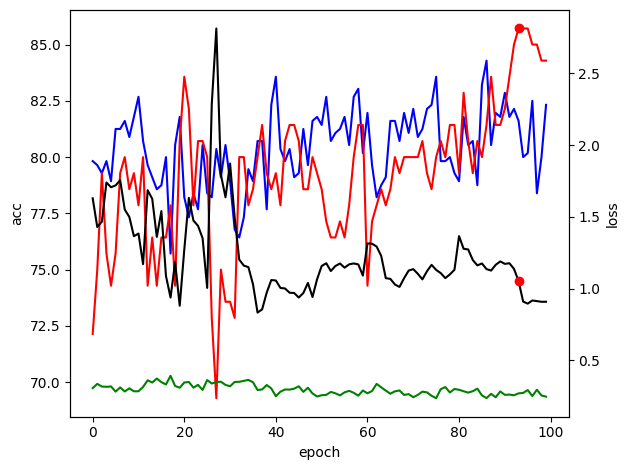

In [ ]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [ ]:
# 새로운 파일 이름으로 모델 저장
torch.save(model.state_dict(), 'b0_1.pt')

In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# 모델 구조 정의 (훈련에 사용된 동일한 모델 구조이어야 함)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6)

# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = additional_dropout.to(device)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('b0_1.pt'))

# 모델을 평가 모드로 전환
model.eval()

# 손실 함수와 평가 지표 정의
criterion = nn.CrossEntropyLoss()

# 정확도와 손실을 계산하는 함수 정의
def evaluate_model(model, dataloader, criterion):
    model.eval()  # 평가 모드로 전환
    running_loss = 0.0
    running_corrects = 0
    num_samples = 0

    with torch.no_grad():  # 평가 시에는 gradient 계산을 하지 않음
        for inputs, labels in dataloader:
            # 입력과 레이블을 GPU로 이동
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 예측 값 구하기
            loss = criterion(outputs, labels)

            # 손실과 정확도 계산
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            num_samples += len(labels)

    epoch_loss = running_loss / num_samples
    epoch_acc = (running_corrects.double() / num_samples).cpu().item() * 100

    return epoch_loss, epoch_acc

# test 데이터셋에 대해 평가
test_loss, test_acc = evaluate_model(model, dataloaders['test'], criterion)

# 결과 출력
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')


Loaded pretrained weights for efficientnet-b0


<ipython-input-129-3107f668c11e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('b0_1.pt'))


Test Loss: 1.1740
Test Accuracy: 80.00%
